In [1]:
from ctypes import sizeof
from tabnanny import verbose
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from pyscf.lo import Boys
from pyscf.lo import PM
from qiskit_nature.units import DistanceUnit
import numpy as np  
from pyscf.tools import molden

/Users/arnab/arnab/workspace/.venv/lib/python3.9/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
fci_energies=[]
fci_ecores=[]

In [3]:

for dist in [0.75,0.8,0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.95, 2.1, 2.25, 2.4, 2.55,2.7, 2.85, 3.0]:

        atom = f"""F  0.0  0.0  0.0;F  {dist} 0.0  0.0"""
        
        # Set up driver and problem
        driver = PySCFDriver(
                atom=atom,
                basis="cc-pvdz",
                charge=0,
                spin=0,
                unit=DistanceUnit.ANGSTROM
        )
        problem = driver.run()
        
        transformer = ActiveSpaceTransformer(
                num_electrons=10,           
                num_spatial_orbitals=6,    
        )
        problem_reduced = transformer.transform(problem)
        
        # Get Hamiltonian (already includes nuclear repulsion energy)
        hamiltonian = problem_reduced.hamiltonian
        fermionic_op = problem_reduced.hamiltonian.second_q_op()
        mapper = JordanWignerMapper()
        tapered_mapper = problem_reduced.get_tapered_mapper(mapper)
        qubit_op = tapered_mapper.map(fermionic_op)
        # print(qubit_op)
        filename = f"qubit_op_F2_tapered_{dist:.2f}.npy"
        np.save(filename, qubit_op)
        eigenvalues, eigenvectors=np.linalg.eig(qubit_op.to_matrix())
        print(np.min(eigenvalues))
        fci_energies.append(np.min(eigenvalues))
        ecore = problem_reduced.hamiltonian.constants
        print("Core energy (ecore):", ecore)    
        fci_ecores.append(ecore)
    


(-38.11671361250568+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 57.15113877936, 'ActiveSpaceTransformer': -216.160302740801}
(-38.71693734867731-3.944301927901306e-31j)
Core energy (ecore): {'nuclear_repulsion_energy': 53.57919260564999, 'ActiveSpaceTransformer': -212.44635816062296}
(-38.06625997157807+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 50.427475393552946, 'ActiveSpaceTransformer': -210.2764530783138}
(-37.46995402756953+0j)
Core energy (ecore): {'nuclear_repulsion_energy': 47.6259489828, 'ActiveSpaceTransformer': -208.3104263589228}
(-36.919342922264896+1.3491747244960862e-16j)
Core energy (ecore): {'nuclear_repulsion_energy': 45.11932008896842, 'ActiveSpaceTransformer': -206.52724395529717}
(-36.40735907765483+1.675555028519049e-15j)
Core energy (ecore): {'nuclear_repulsion_energy': 42.863354084520005, 'ActiveSpaceTransformer': -204.9082221381748}
(-35.47768137720239+1.7319426281784695e-15j)
Core energy (ecore): {'nuclear_repulsion_energy': 38.9666855313

In [4]:
print("FCI energies:", fci_energies)
print("FCI core energies:", fci_ecores)

FCI energies: [(-38.11671361250568+0j), (-38.71693734867731-3.944301927901306e-31j), (-38.06625997157807+0j), (-37.46995402756953+0j), (-36.919342922264896+1.3491747244960862e-16j), (-36.40735907765483+1.675555028519049e-15j), (-35.47768137720239+1.7319426281784695e-15j), (-34.64951883239394+0j), (-33.90534113790184+0j), (-33.23465195519002+0j), (-32.63060258326116+0j), (-32.08770381561204+0j), (-31.600349334873233+0j), (-31.16262286472037-2.6388913224016684e-33j), (-30.58648965286224+0j), (-30.091575266521115+1.645155874487199e-23j), (-29.66347130300154+0j), (-29.290504844269943+0j), (-28.96316924237902+0j), (-28.6736848181768+0j), (-28.415716484048893+0j), (-28.184161145302085+0j)]
FCI core energies: [{'nuclear_repulsion_energy': 57.15113877936, 'ActiveSpaceTransformer': -216.160302740801}, {'nuclear_repulsion_energy': 53.57919260564999, 'ActiveSpaceTransformer': -212.44635816062296}, {'nuclear_repulsion_energy': 50.427475393552946, 'ActiveSpaceTransformer': -210.2764530783138}, {'nu

In [5]:
import matplotlib.pyplot as plt

fci_total = []
for i in range(len(fci_energies)):
    # Extract core energies from dictionary
    nuclear_repulsion = fci_ecores[i]['nuclear_repulsion_energy']
    core_correction = fci_ecores[i]['ActiveSpaceTransformer']
    # Add all contributions to get total energy
    fci_energies_tot = fci_energies[i].real + nuclear_repulsion + core_correction
    fci_total.append(fci_energies_tot)

print("FCI total energies:", fci_total)

distance=[0.75,0.8,0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.95, 2.1, 2.25, 2.4, 2.55,2.7, 2.85, 3.0]

FCI total energies: [-197.1258775739467, -197.5841029036503, -197.91523765633895, -198.15443140369234, -198.32726678859365, -198.45222713130963, -198.60758216798655, -198.68741633840932, -198.7267949934633, -198.74421036901248, -198.7496899775973, -198.7489007188604, -198.74514104972113, -198.74034114202874, -198.73343254328302, -198.7281880978031, -198.7248880869013, -198.7231872366366, -198.72254932133396, -198.7224911853184, -198.72268310619205, -198.7229453043483]


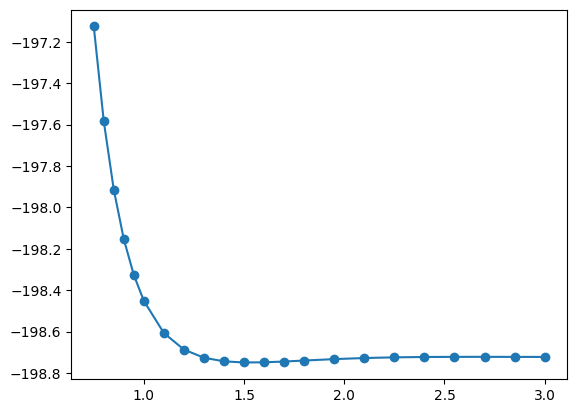

In [6]:
plt.plot(distance, fci_total, marker='o', label='FCI Total Energy')